In [1]:
import requests
import os
import zipfile
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/Users/helenarusso/opt/miniconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# HIV status (Supplementary Figure 5a)

In [2]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = 'ee34ee95908749dd81ee9a62fbdac98e'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../HNRC_metadata.tsv', sep='\t') #not publicly available
column_interest = 'hiv' #this is the column in the metadata table we will work with

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')

File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [3]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table for box plots
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', column_interest]],
                                  on='filename', how='left')
ftable_filtered_merged = ftable_filtered_merged.fillna('not available')

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
last_column = ftable_filtered_merged.iloc[:, -1]
ftable_filtered_merged = pd.concat([last_column, ftable_filtered_merged.iloc[:, :-1]], axis=1)
ftable_filtered_merged[column_interest] = ftable_filtered_merged[column_interest].astype(str)
ftable_filtered_merged = ftable_filtered_merged.sort_values(by=column_interest, ascending=True)

ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest] != 'not available']
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest] != 'Blank_QC']


In [4]:
#reorganize the column order
metadata = pd.read_csv('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/FastMASST_searches/deltas_annotation_reordered.txt', sep='\t')
metadata['order'] = metadata['order'].astype(str).str.zfill(3)
ms_features = pd.DataFrame(ftable_filtered_merged.columns[2:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]
ms_features['annotation'] = ms_features['annotation'].str.replace(' ','')
ms_features = pd.merge(ms_features, metadata[['annotation','order']], on='annotation', how='left')
ms_features['order'] = ms_features['order'].astype(str) + '_'+ ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features_reordered = ms_features.sort_values(by='order', ascending=True)

ordered_feature_names = ms_features_reordered['MS_#Scan#'].tolist()

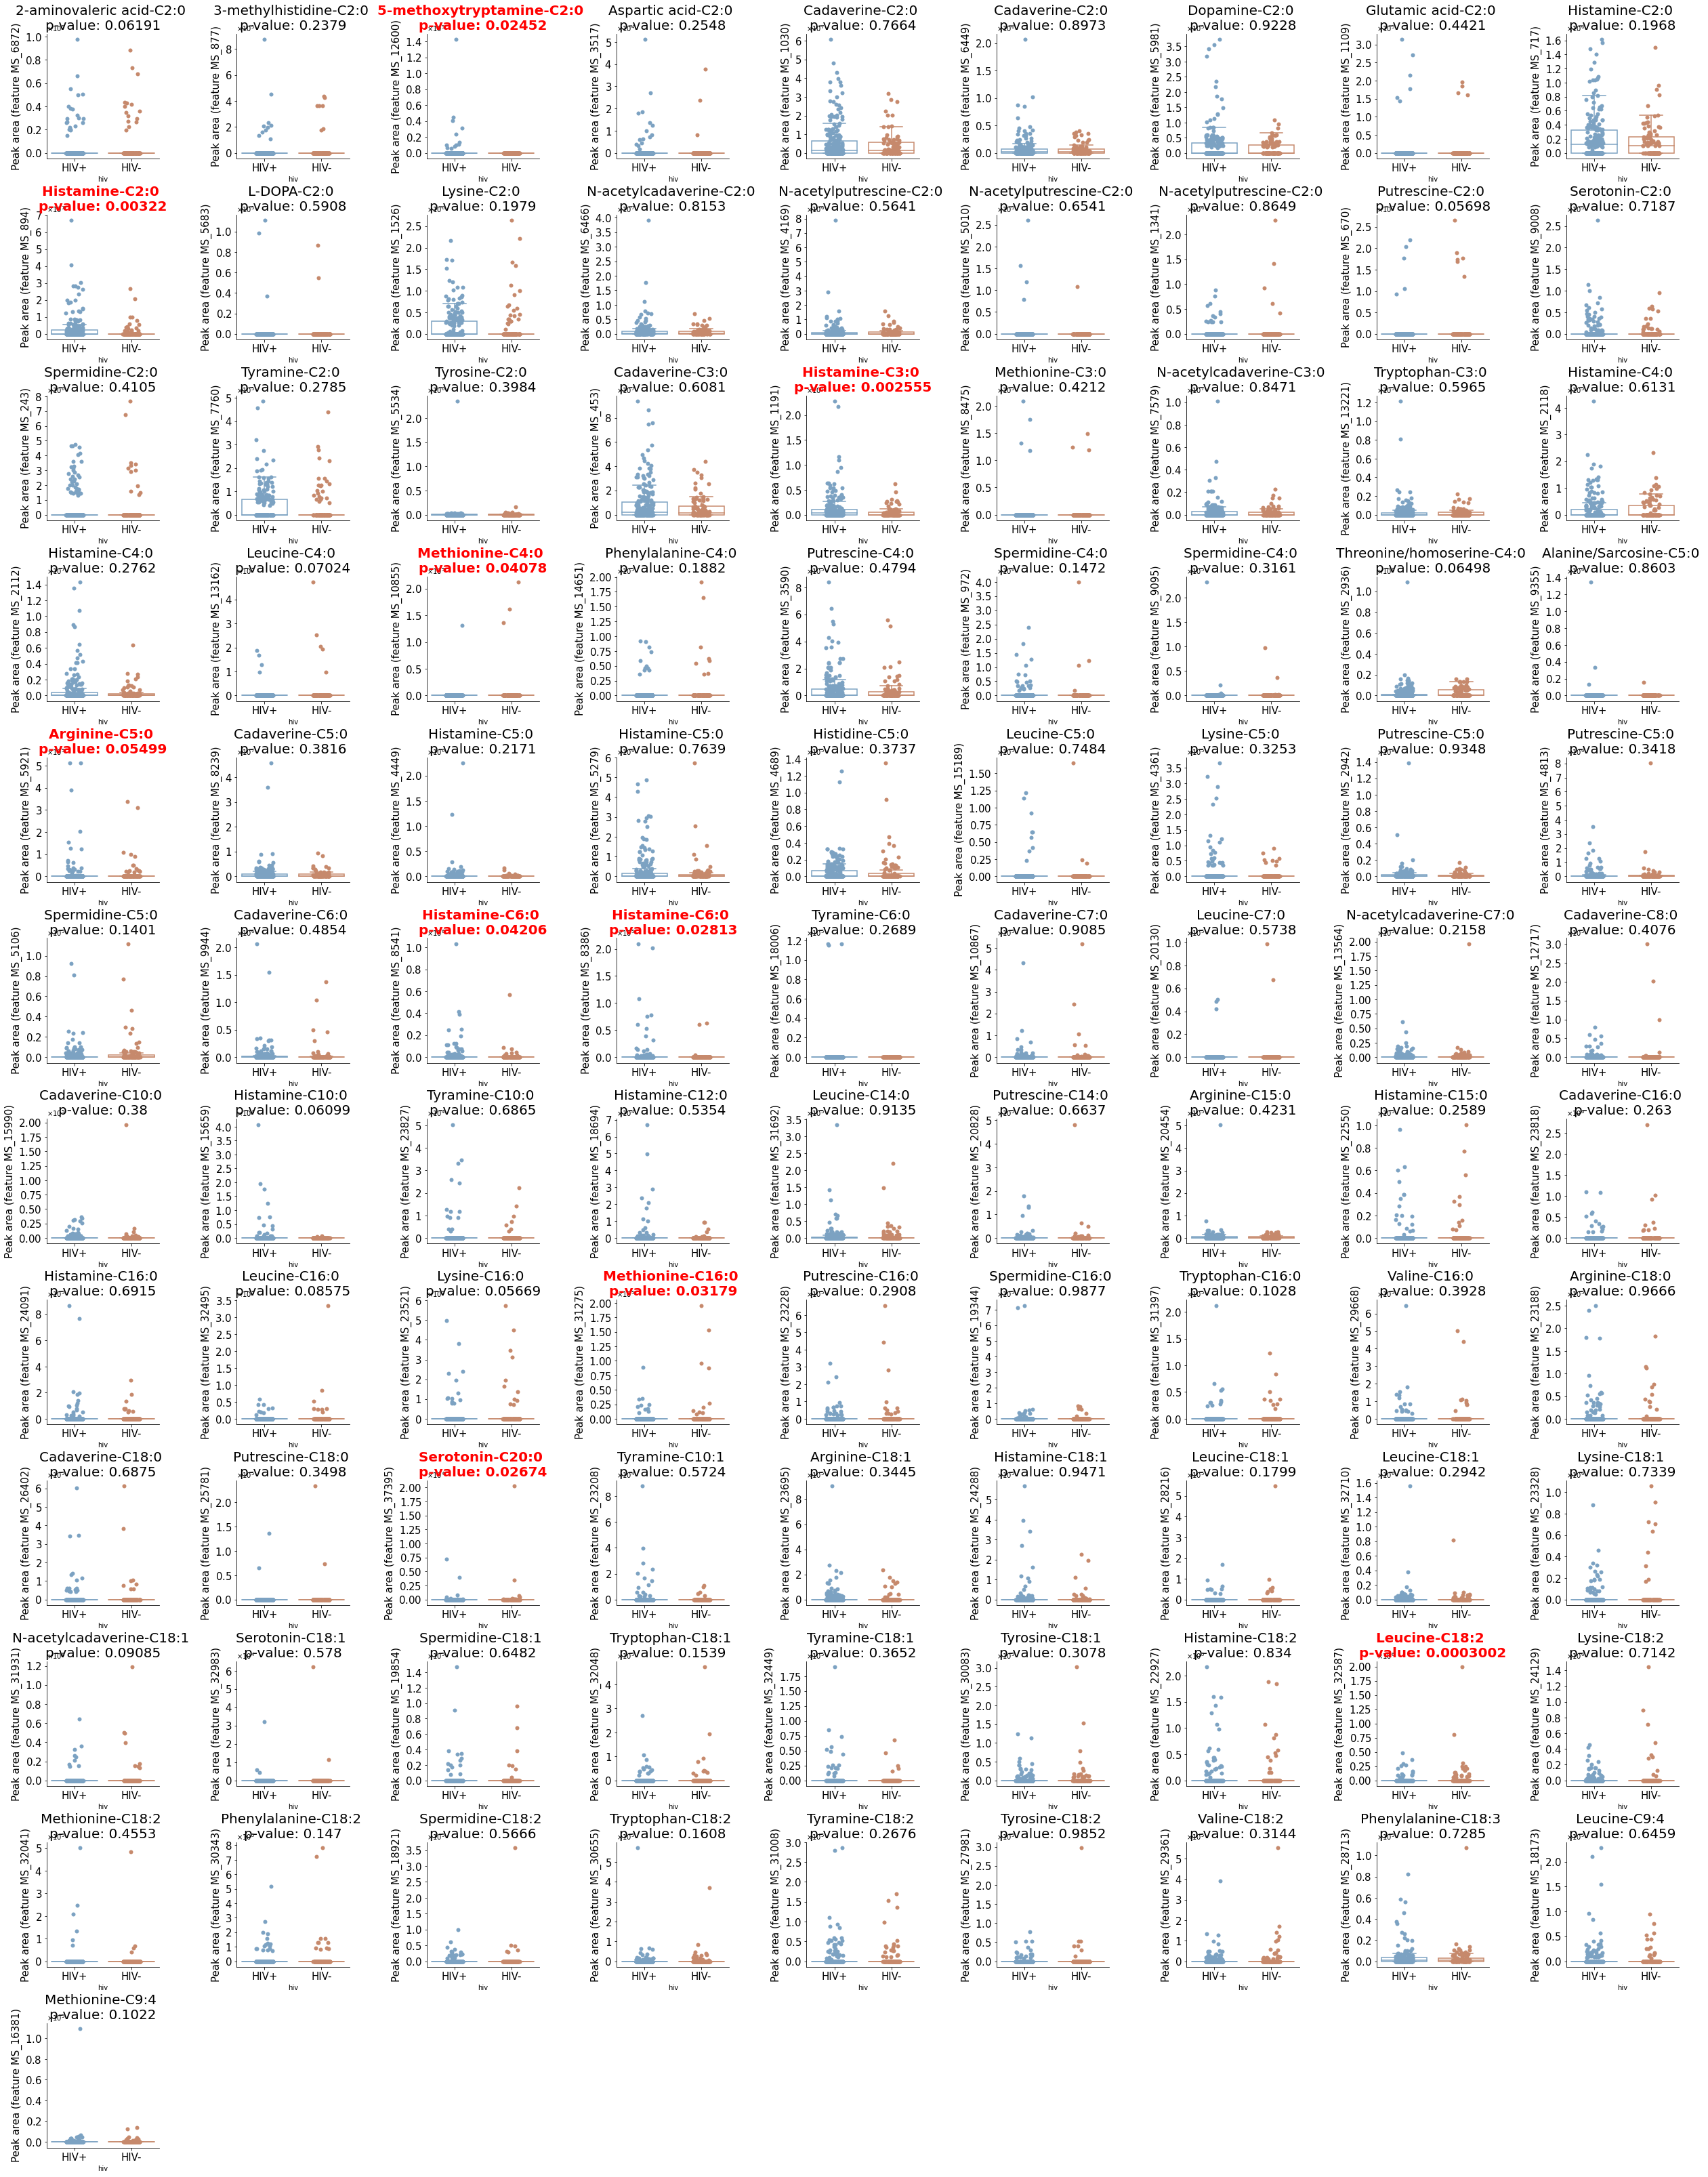

In [5]:
from matplotlib.ticker import FuncFormatter

# Placeholder dictionary to hold p-values
p_values = {}

# Assuming 'column_interest' splits the data into two groups
group_labels = ftable_filtered_merged[column_interest].unique()
if len(group_labels) != 2:
    raise ValueError("column_interest must divide the data into exactly two groups for a Mann-Whitney U test.")

for feature_name in ordered_feature_names:  # Use the ordered list for loop
    # Data for the two groups
    data_group1 = ftable_filtered_merged[ftable_filtered_merged[column_interest] == group_labels[0]][feature_name]
    data_group2 = ftable_filtered_merged[ftable_filtered_merged[column_interest] == group_labels[1]][feature_name]
    
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided', use_continuity=True)
    p_values[feature_name] = p_value

#plot
plt.figure(figsize=(35, 60))  # Adjust the figure size as needed

unique_values = ftable_filtered_merged[column_interest].unique().tolist()
ftable_filtered_merged[column_interest] = pd.Categorical(
    ftable_filtered_merged[column_interest], categories=unique_values, ordered=True)

# Function to generate a color palette
def generate_palette(n):
    return sns.color_palette("twilight_shifted", n)

# Assigning palette
my_pal = generate_palette(len(unique_values))
color_dict = {str(val): color for val, color in zip(unique_values, my_pal)}
color_dict_white = {key: 'white' for key in color_dict.keys()}

for i, feature_name in enumerate(ordered_feature_names, 1):
    title_name = library_matches.loc[library_matches['MS_#Scan#'] == feature_name, 'Compound_Name_simplified'].iloc[0]
    plt.subplot(15, 9, i)
    fig = sns.boxplot(x=column_interest, y=feature_name, data=ftable_filtered_merged, notch=False, 
                      palette=color_dict_white, showfliers=False)
    
    # Set box properties including edge color to match your palette
    for j, patch in enumerate(fig.artists):
        col = color_dict[ftable_filtered_merged[column_interest].unique()[j]]
        patch.set_edgecolor(col)

        num_lines = len(fig.lines)
        start_line_index = 6 * j
        end_line_index = start_line_index + 6
        for k in range(start_line_index, min(end_line_index, num_lines)):
            line = fig.lines[k]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Add colored dots for each category
    for diet in ftable_filtered_merged[column_interest].unique():
        sns.stripplot(
            x=column_interest, 
            y=feature_name, 
            data=ftable_filtered_merged[ftable_filtered_merged[column_interest] == diet], 
            color=color_dict[diet], 
            jitter=0.15, 
            size=6,
            ax=fig
        )
        
    # Set the y-axis to use scientific notation
    fig.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    fig.yaxis.get_major_formatter().set_scientific(True)
    fig.yaxis.get_major_formatter().set_powerlimits((-1, 1)) 
        
    # Determine title color based on p-value
    if p_values[feature_name] <= 0.055:
        title_color = 'red'
        title_weight = 'bold'
    else:
        title_color = 'black'
        title_weight = 'normal'
        
    fig.set_ylabel(f'Peak area (feature {feature_name})', fontsize=15)
    formatted_p_value = f"{p_values[feature_name]:.4}"
    plt.title(f'{title_name}\np-value: {formatted_p_value}', fontsize=20, color=title_color, fontweight=title_weight)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
plt.tight_layout()
plt.subplots_adjust(top=0.91)
sns.despine()

plt.savefig("/.../Supplementary_Figure_5a.pdf")
plt.show()


# Neurocognition (Supplementary Figure 5c)

In [6]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = 'ee34ee95908749dd81ee9a62fbdac98e'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../HNRC_metadata.tsv', sep='\t') #not publicly available
column_interest = 'global_impairment_pe' #this is the column in the metadata table we will work with

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')

File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [7]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table for box plots
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', column_interest]],
                                  on='filename', how='left')
ftable_filtered_merged = ftable_filtered_merged.fillna('not available')

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
last_column = ftable_filtered_merged.iloc[:, -1]
ftable_filtered_merged = pd.concat([last_column, ftable_filtered_merged.iloc[:, :-1]], axis=1)
ftable_filtered_merged[column_interest] = ftable_filtered_merged[column_interest].astype(str)
ftable_filtered_merged = ftable_filtered_merged.sort_values(by=column_interest, ascending=True)

ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest] != 'not available']
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest] != 'Blank_QC']


In [8]:
#reorganize the column order
metadata = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
metadata['order'] = metadata['order'].astype(str).str.zfill(3)
ms_features = pd.DataFrame(ftable_filtered_merged.columns[2:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]
ms_features['annotation'] = ms_features['annotation'].str.replace(' ','')
ms_features = pd.merge(ms_features, metadata[['annotation','order']], on='annotation', how='left')
ms_features['order'] = ms_features['order'].astype(str) + '_'+ ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features_reordered = ms_features.sort_values(by='order', ascending=True)

ordered_feature_names = ms_features_reordered['MS_#Scan#'].tolist()

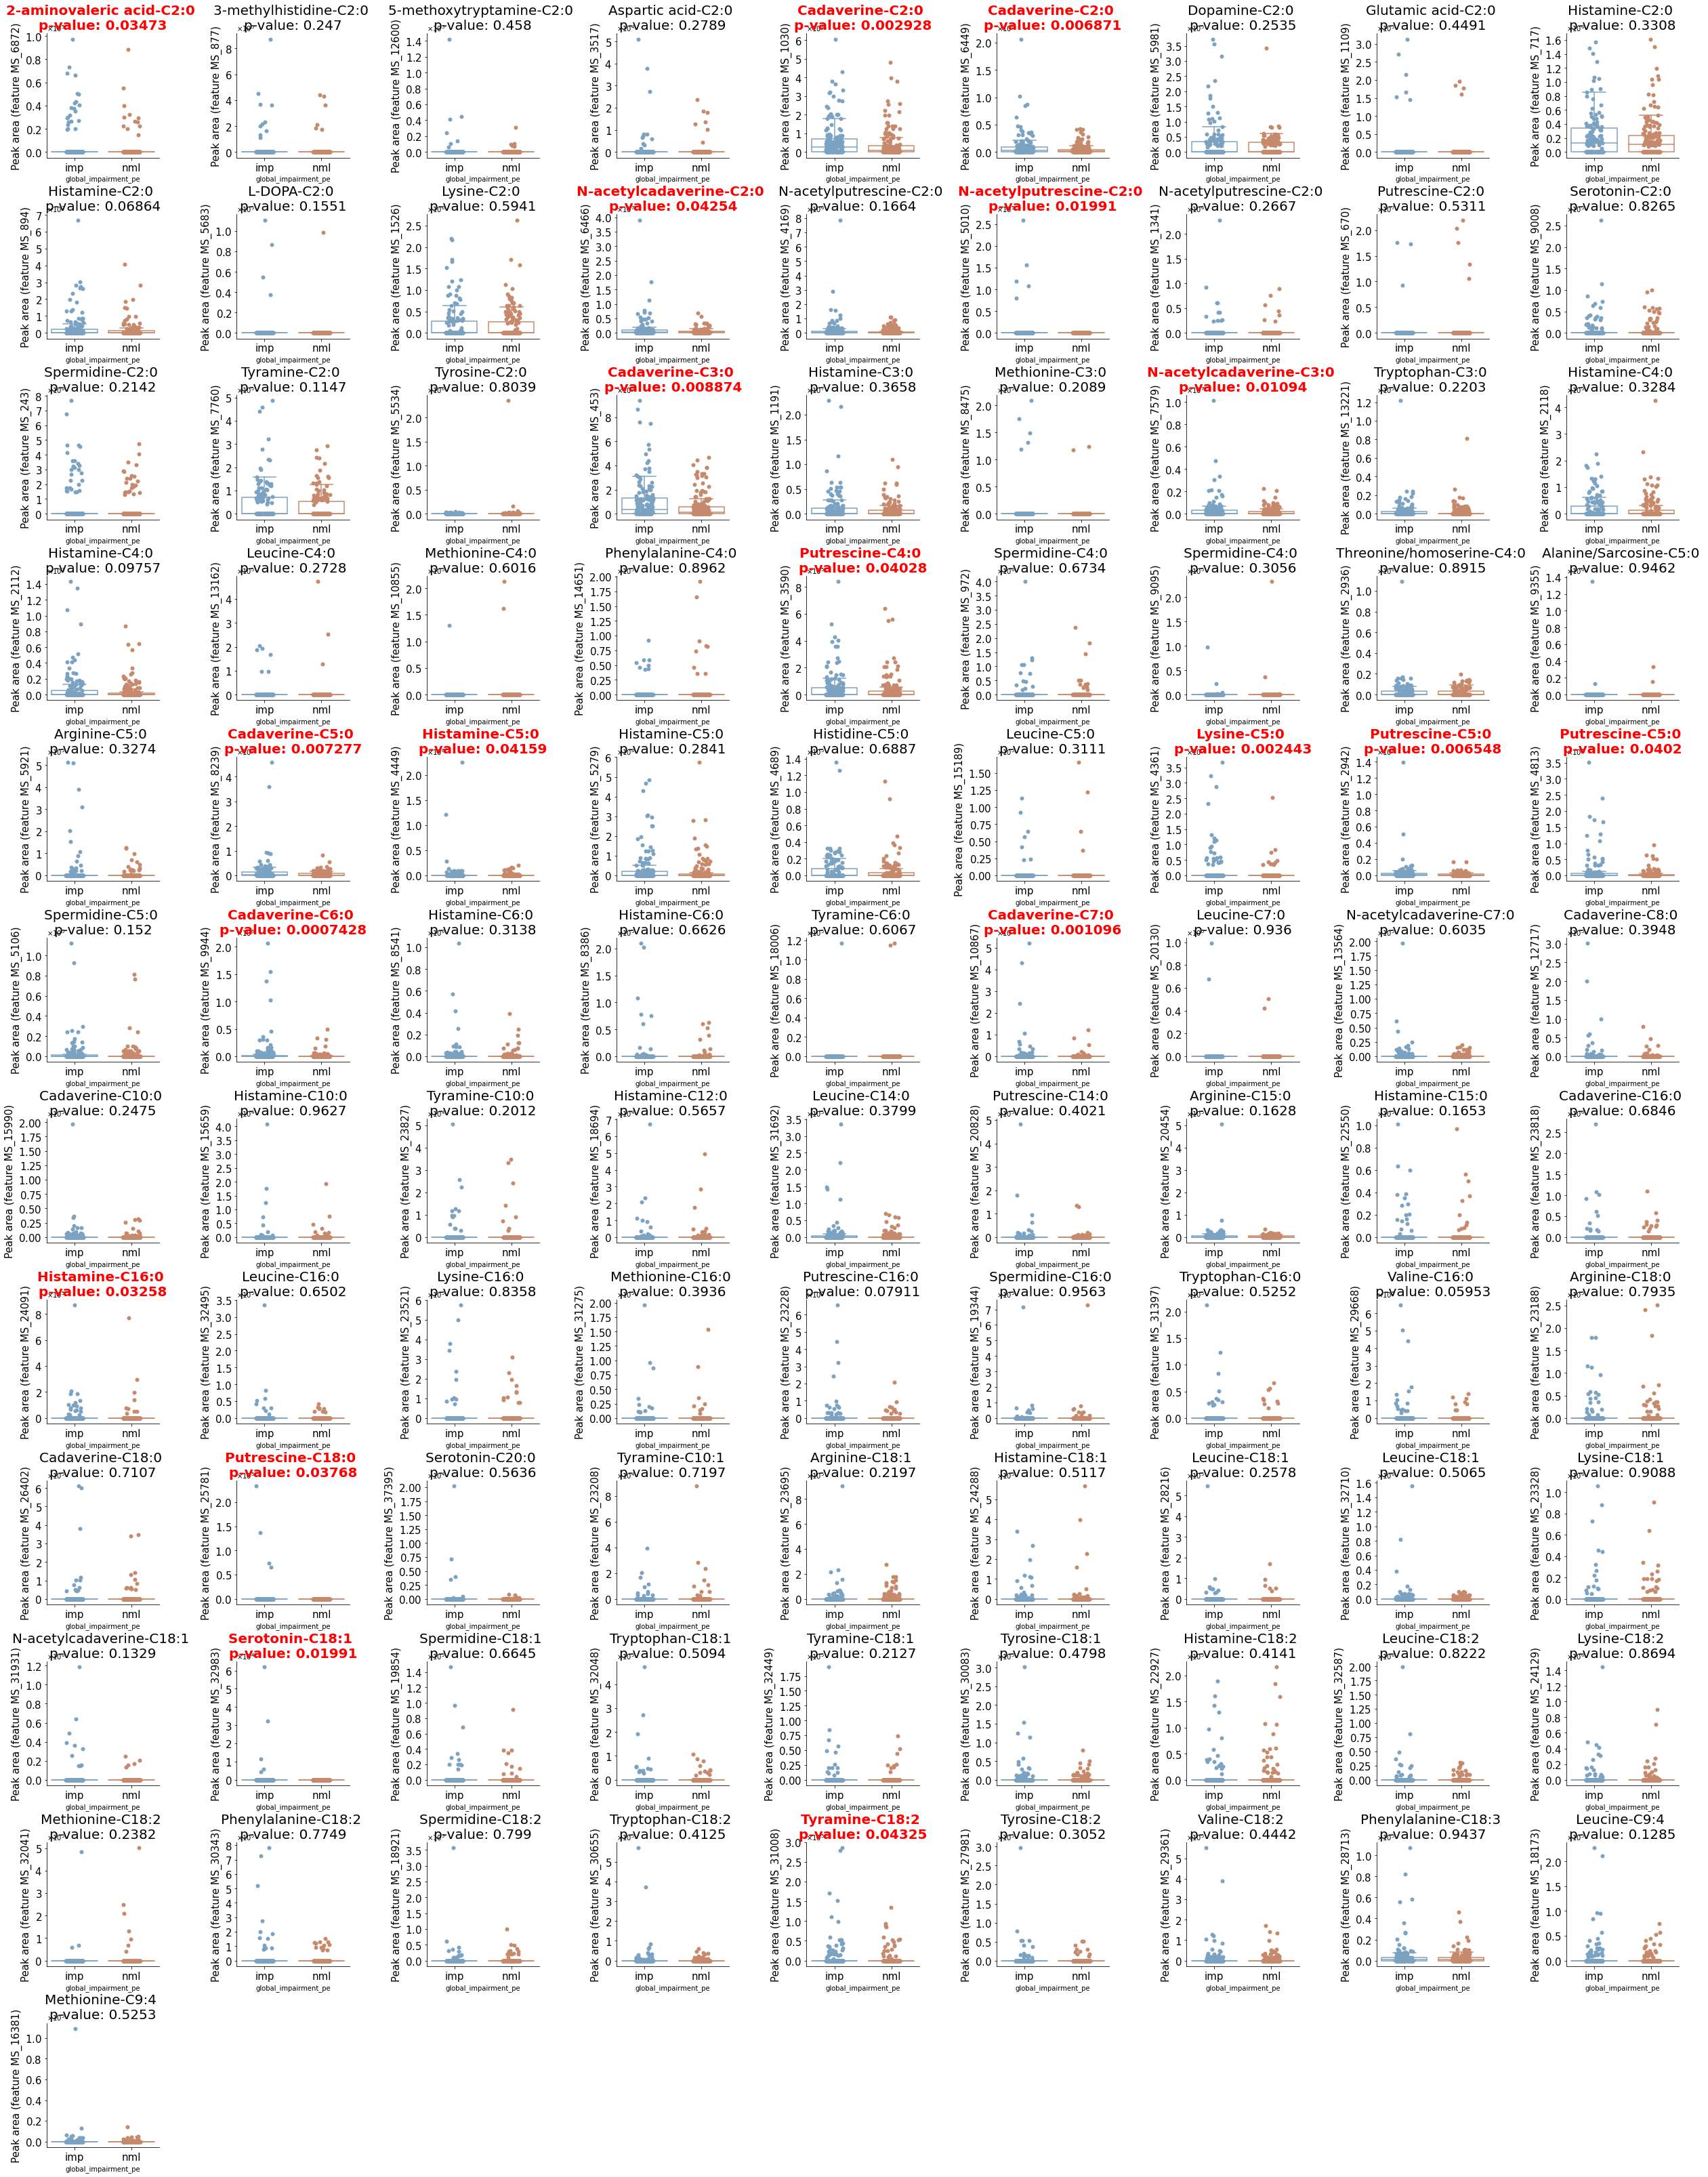

In [9]:
from matplotlib.ticker import FuncFormatter

# Placeholder dictionary to hold p-values
p_values = {}

# Assuming 'column_interest' splits the data into two groups
group_labels = ftable_filtered_merged[column_interest].unique()
if len(group_labels) != 2:
    raise ValueError("column_interest must divide the data into exactly two groups for a Mann-Whitney U test.")

for feature_name in ordered_feature_names:  # Use the ordered list for loop
    # Data for the two groups
    data_group1 = ftable_filtered_merged[ftable_filtered_merged[column_interest] == group_labels[0]][feature_name]
    data_group2 = ftable_filtered_merged[ftable_filtered_merged[column_interest] == group_labels[1]][feature_name]
    
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided', use_continuity=True)
    p_values[feature_name] = p_value

#plot
plt.figure(figsize=(35, 60))  # Adjust the figure size as needed

unique_values = ftable_filtered_merged[column_interest].unique().tolist()
ftable_filtered_merged[column_interest] = pd.Categorical(
    ftable_filtered_merged[column_interest], categories=unique_values, ordered=True)

# Function to generate a color palette
def generate_palette(n):
    return sns.color_palette("twilight_shifted", n)

# Assigning palette
my_pal = generate_palette(len(unique_values))
color_dict = {str(val): color for val, color in zip(unique_values, my_pal)}
color_dict_white = {key: 'white' for key in color_dict.keys()}

for i, feature_name in enumerate(ordered_feature_names, 1):
    title_name = library_matches.loc[library_matches['MS_#Scan#'] == feature_name, 'Compound_Name_simplified'].iloc[0]
    plt.subplot(15, 9, i)
    fig = sns.boxplot(x=column_interest, y=feature_name, data=ftable_filtered_merged, notch=False, 
                      palette=color_dict_white, showfliers=False)
    
    # Set box properties including edge color to match your palette
    for j, patch in enumerate(fig.artists):
        col = color_dict[ftable_filtered_merged[column_interest].unique()[j]]
        patch.set_edgecolor(col)

        num_lines = len(fig.lines)
        start_line_index = 6 * j
        end_line_index = start_line_index + 6
        for k in range(start_line_index, min(end_line_index, num_lines)):
            line = fig.lines[k]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Add colored dots for each category
    for diet in ftable_filtered_merged[column_interest].unique():
        sns.stripplot(
            x=column_interest, 
            y=feature_name, 
            data=ftable_filtered_merged[ftable_filtered_merged[column_interest] == diet], 
            color=color_dict[diet], 
            jitter=0.15, 
            size=6,
            ax=fig
        )
        
    # Set the y-axis to use scientific notation
    fig.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    fig.yaxis.get_major_formatter().set_scientific(True)
    fig.yaxis.get_major_formatter().set_powerlimits((-1, 1)) 
        
    # Determine title color based on p-value
    if p_values[feature_name] <= 0.055:
        title_color = 'red'
        title_weight = 'bold'
    else:
        title_color = 'black'
        title_weight = 'normal'
        
    fig.set_ylabel(f'Peak area (feature {feature_name})', fontsize=15)
    formatted_p_value = f"{p_values[feature_name]:.4}"
    plt.title(f'{title_name}\np-value: {formatted_p_value}', fontsize=20, color=title_color, fontweight=title_weight)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
plt.tight_layout()
plt.subplots_adjust(top=0.91)
sns.despine()

plt.savefig("/.../Supplementary_Figure_5c.pdf")
plt.show()
